In [2]:
import os
import sys
from pathlib import Path
import pandas as pd
import joblib

In [18]:
# 获取项目根目录
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

# 导入数据
processed_path = Path(project_root) / 'data' / 'processed'
learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')

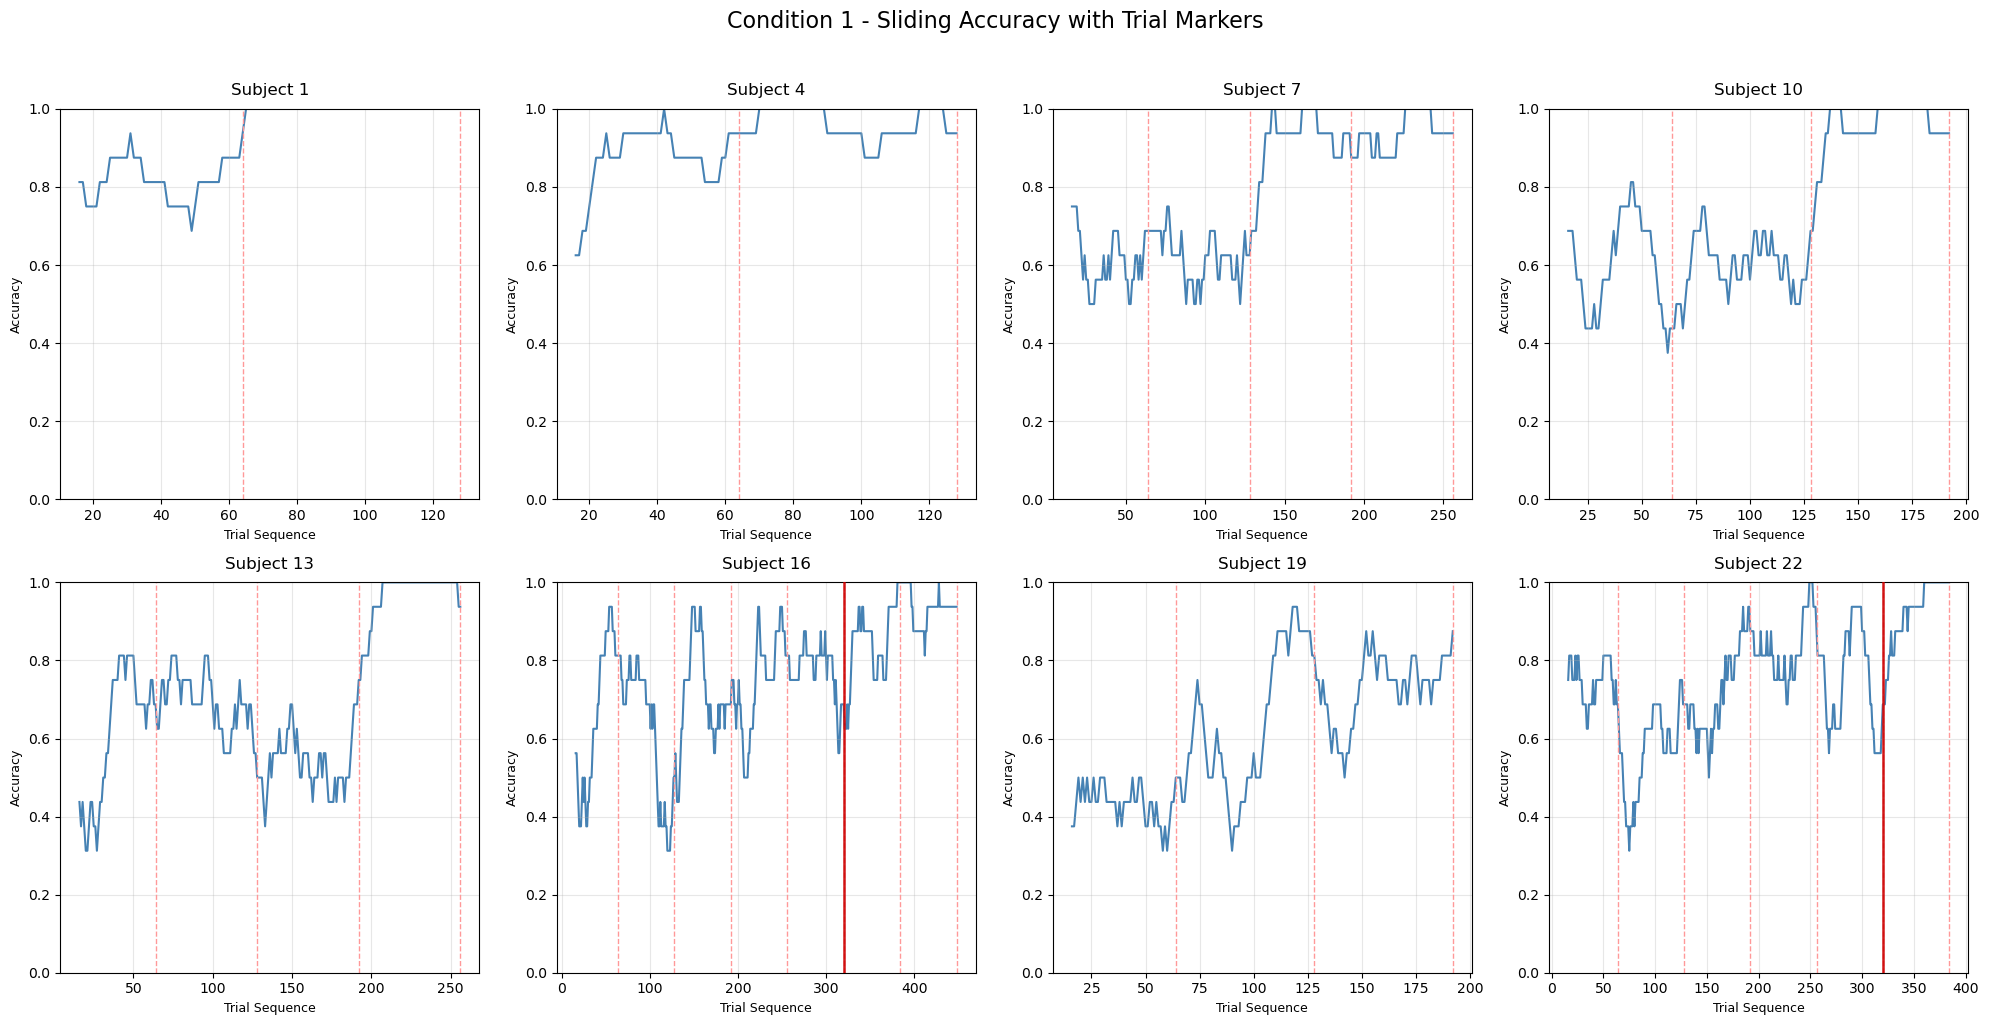

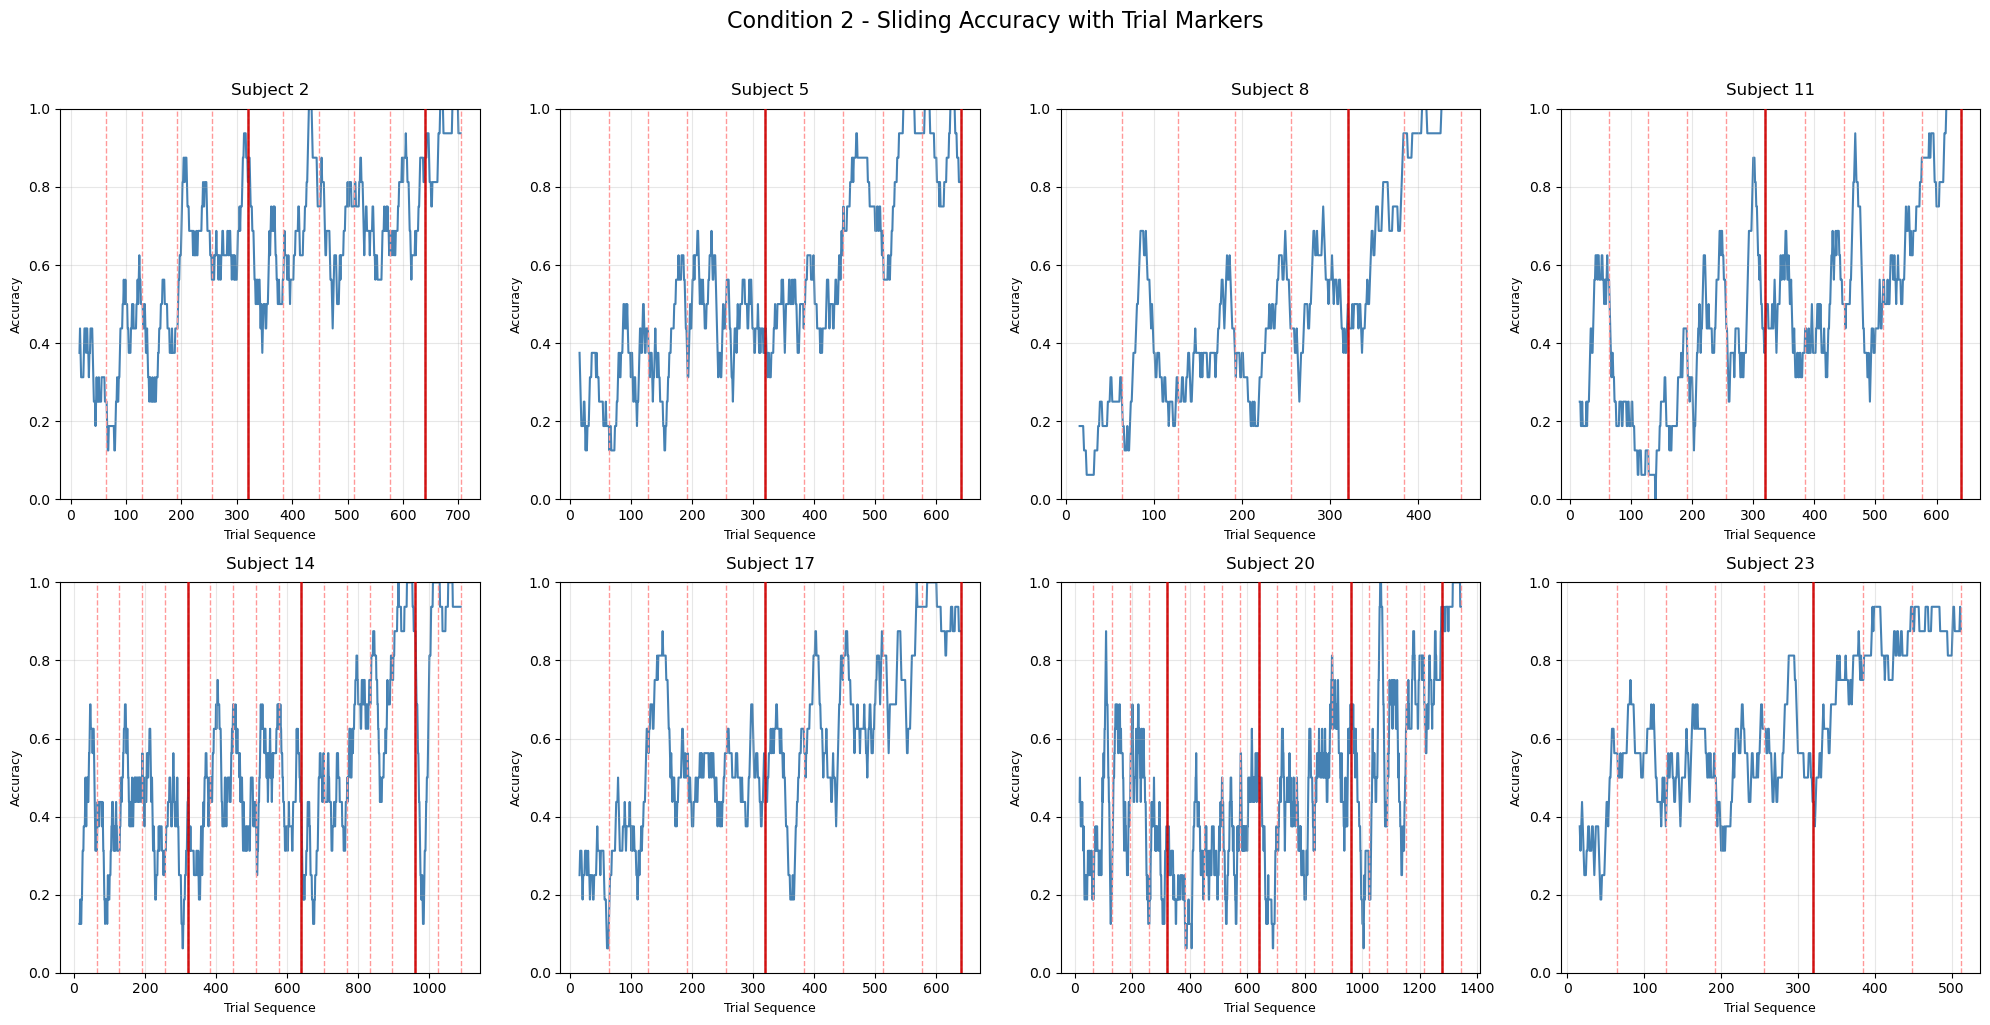

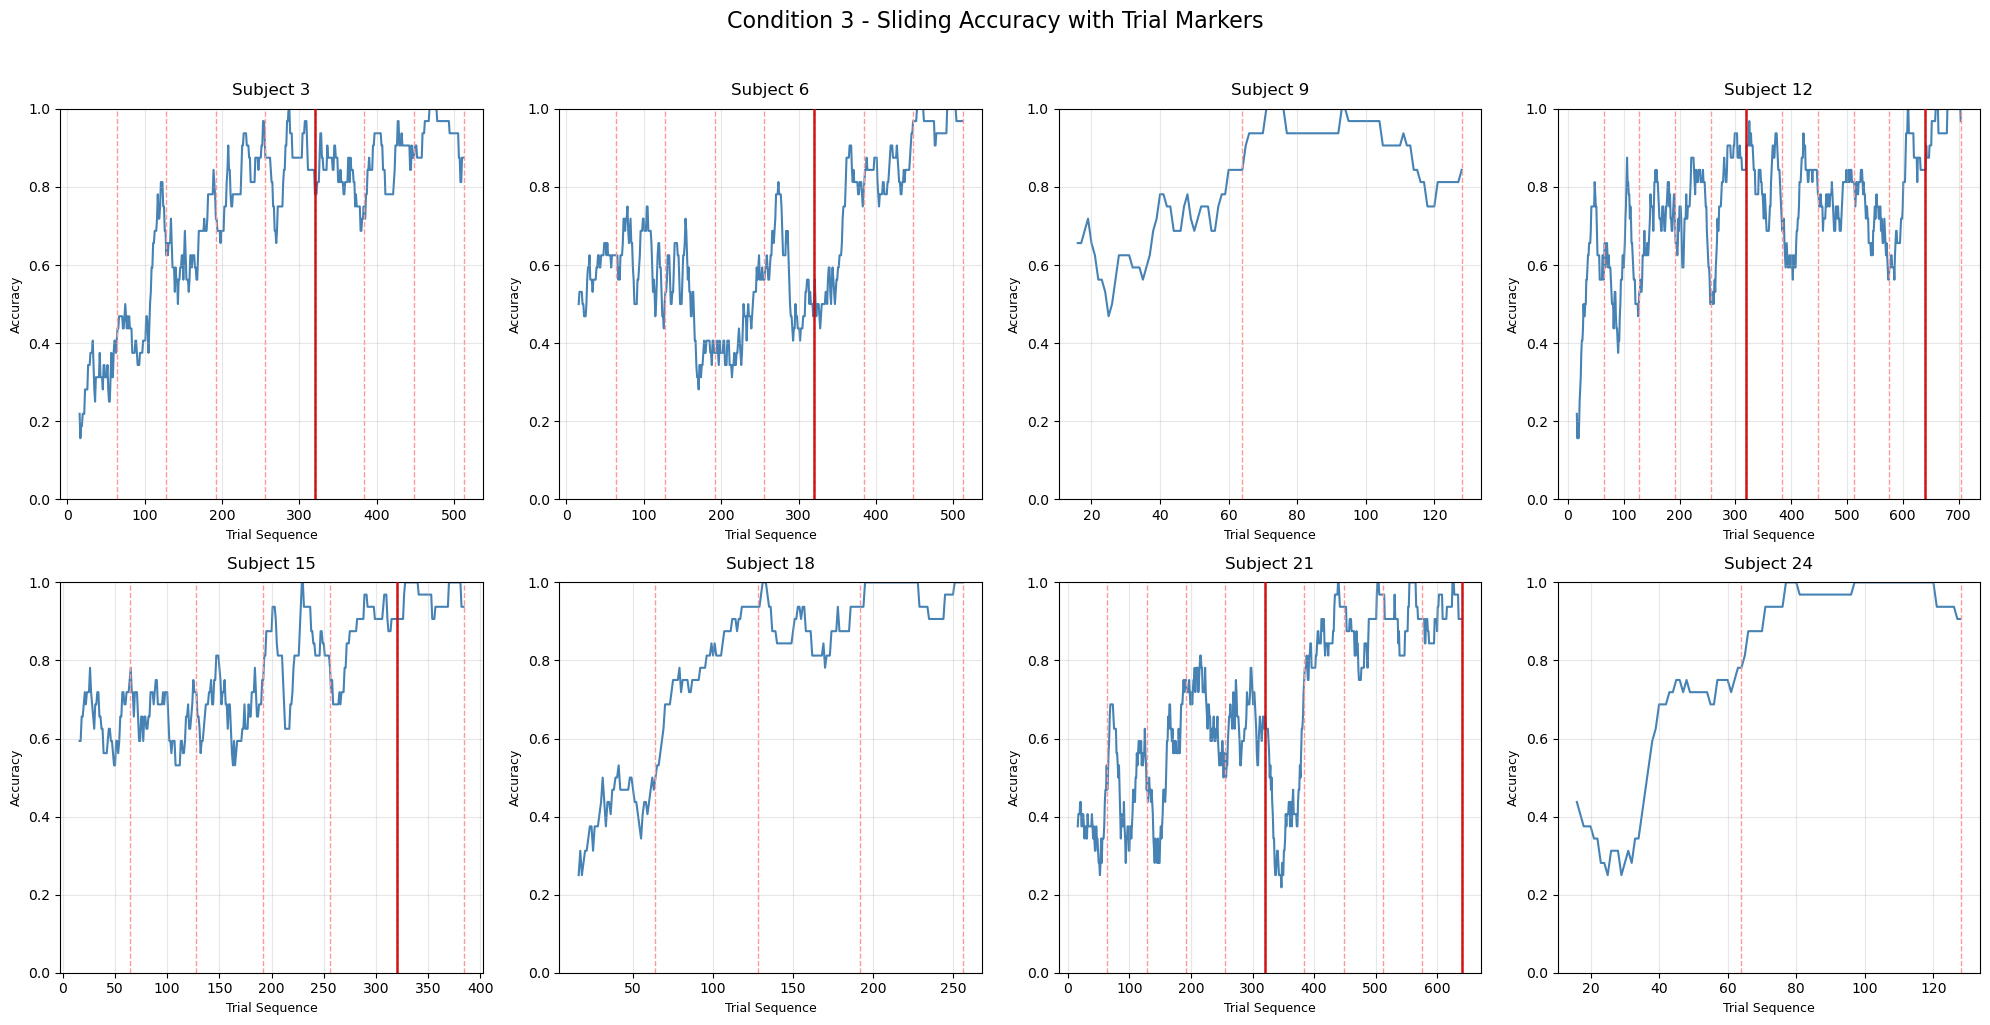

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# 生成每个被试内部的试次编号
learning_data['trial_in_sub'] = learning_data.groupby('iSub').cumcount() + 1

# 计算滑动窗口正确率
learning_data['rolling_accuracy'] = learning_data.groupby('iSub')['feedback'].transform(
    lambda x: x.rolling(16, min_periods=16).mean()
)

# 配置参数
MAX_COLS = 4
LIGHT_RED = '#FF9999'
DARK_RED = '#CC0000'

for cond in sorted(learning_data['condition'].unique()):
    cond_data = learning_data[learning_data['condition'] == cond]
    subjects = cond_data['iSub'].unique()
    n_subs = len(subjects)
    
    if n_subs == 0:
        continue
    
    # 创建画布
    n_cols = min(MAX_COLS, n_subs)
    n_rows = (n_subs + n_cols - 1) // n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows), 
                           squeeze=False, facecolor='white')
    fig.suptitle(f'Condition {cond} - Sliding Accuracy with Trial Markers', 
                fontsize=16, y=1.02)
    
    for idx, sub in enumerate(subjects):
        row = idx // n_cols
        col = idx % n_cols
        ax = axs[row, col]
        
        sub_df = cond_data[cond_data['iSub'] == sub]
        valid_data = sub_df.dropna(subset=['rolling_accuracy'])
        
        if valid_data.empty:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
            ax.set_title(f'Subject {sub}')
            continue
            
        # 绘制主曲线
        ax.plot(valid_data['trial_in_sub'], valid_data['rolling_accuracy'],
                color='steelblue', linewidth=1.5, zorder=1)
        
        # 绘制分割线
        max_trial = valid_data['trial_in_sub'].max()
        
        # 64试次分割线
        for x in range(64, max_trial+1, 64):
            ax.axvline(x=x, color=LIGHT_RED, linestyle='--', 
                      linewidth=1, alpha=1, zorder=2)
            
        # 320试次分割线
        for x in range(320, max_trial+1, 320):
            ax.axvline(x=x, color=DARK_RED, linestyle='-',
                      linewidth=1.8, alpha=0.9, zorder=3)
        
        # 坐标轴设置
        ax.set_ylim(0, 1)
        ax.set_yticks([i/5 for i in range(6)])
        ax.set_yticklabels([f"{i/5:.1f}" for i in range(6)])
        ax.set_xlabel('Trial Sequence', fontsize=9)
        ax.set_ylabel('Accuracy', fontsize=9)
        ax.set_title(f'Subject {sub}', pad=10, fontsize=12)
        ax.grid(True, alpha=0.3)
        
    # 隐藏空白子图
    for idx in range(n_subs, n_rows*n_cols):
        axs.flatten()[idx].axis('off')
        
    plt.tight_layout()
    plt.show()

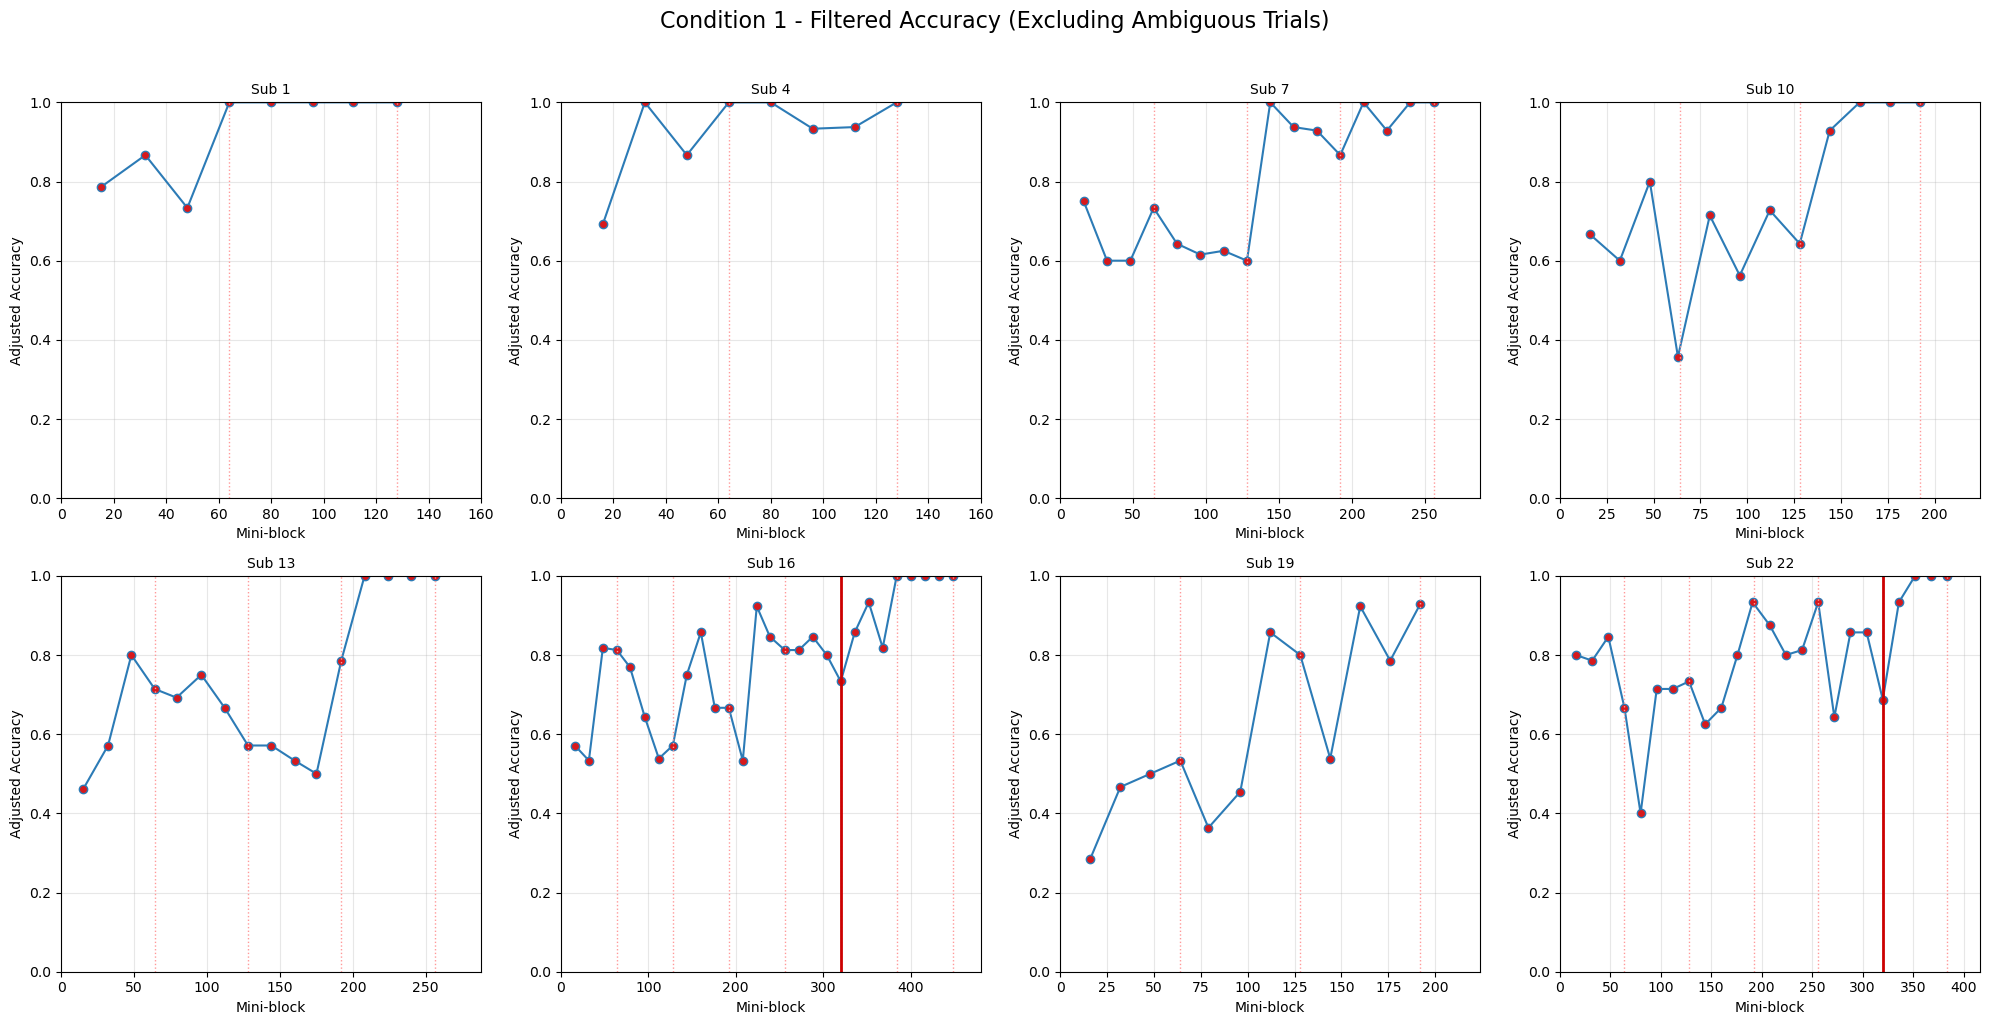

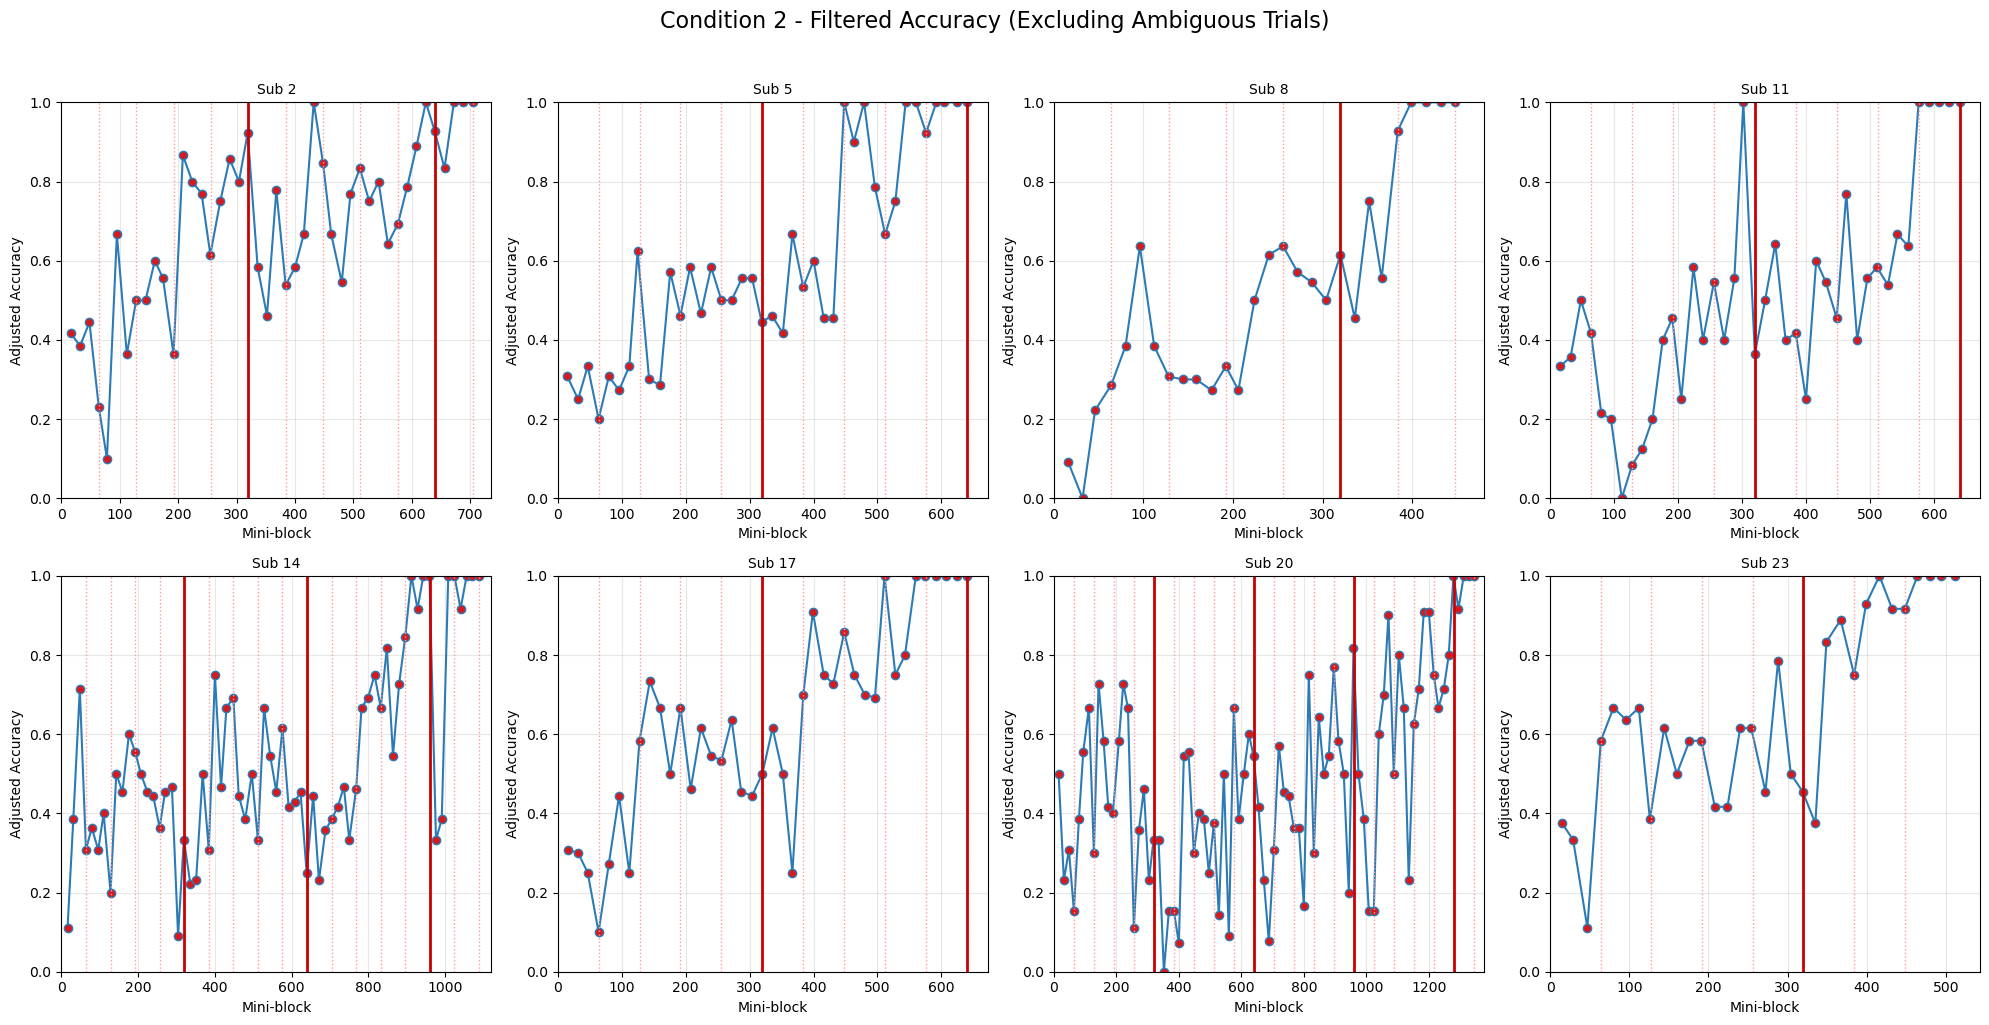

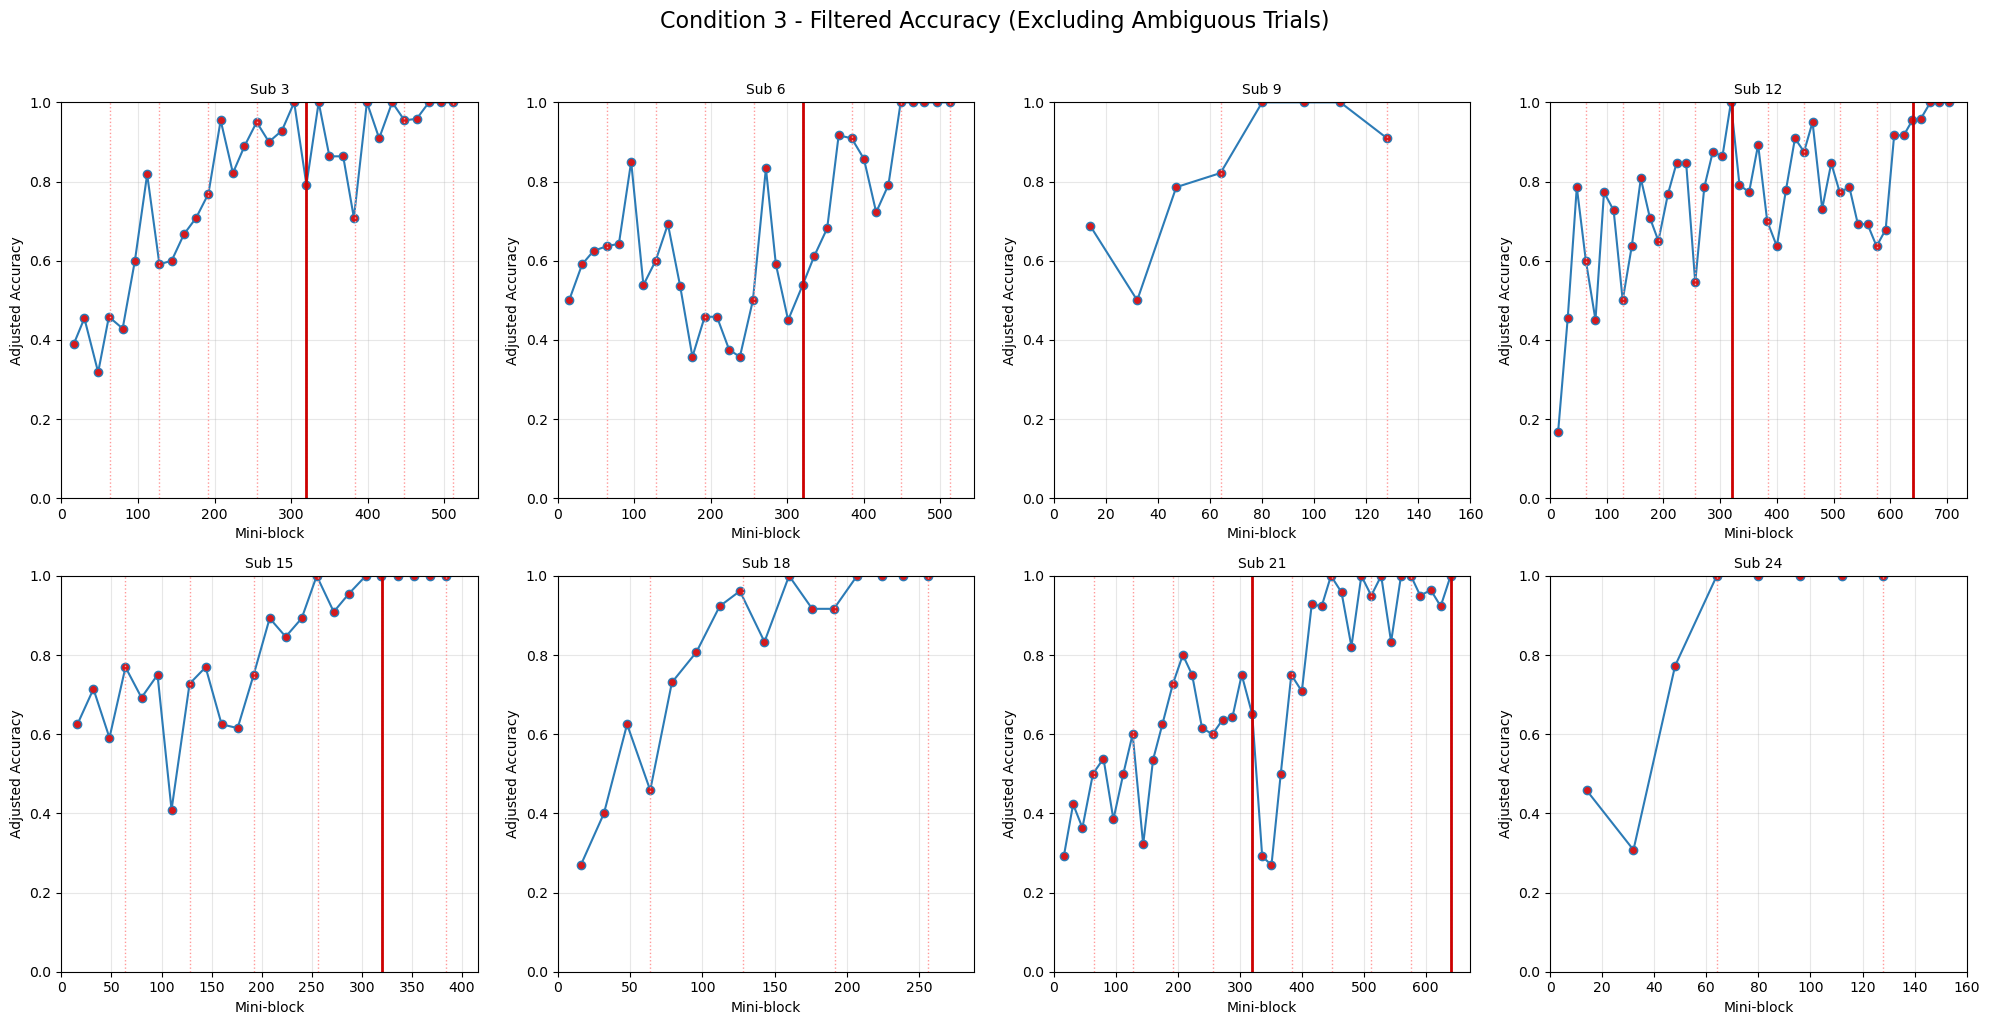

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# 生成被试内试次编号
learning_data['trial_in_sub'] = learning_data.groupby('iSub').cumcount() + 1

# 创建16试次区块编号
learning_data['block'] = (learning_data['trial_in_sub'] - 1) // 16

# 计算过滤后的区块正确率
block_accuracy = (
    learning_data
    .groupby(['iSub', 'block', 'condition'])
    .apply(lambda x: x[x['ambigous'] != 1]  # 过滤ambigous=1的试次
           .iloc[:16]  # 取前16个有效试次（如果需要严格窗口大小） 
           ['feedback'].mean() if len(x[x['ambigous'] != 1]) >= 1 else pd.NA)
    .reset_index(name='accuracy')
)

# 过滤无效数据
block_accuracy = block_accuracy.dropna(subset=['accuracy'])

# 计算区块位置（使用实际有效试次的最大编号）
block_position = (
    learning_data[learning_data['ambigous'] != 1]
    .groupby(['iSub', 'block'])
    .trial_in_sub.max()
    .reset_index(name='x_position')
)

block_accuracy = pd.merge(block_accuracy, block_position, on=['iSub', 'block'])

# 可视化部分（添加过滤逻辑）
LINE_COLOR = '#2c7bb6'
MARKER_COLOR = '#d7191c'

for cond in sorted(block_accuracy['condition'].unique()):
    cond_subs = block_accuracy[block_accuracy['condition'] == cond]['iSub'].unique()
    
    # 创建画布
    n_cols = 4
    n_subs = len(cond_subs)
    n_rows = (n_subs + n_cols - 1) // n_cols
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows), 
                           facecolor='white', squeeze=False)
    fig.suptitle(f'Condition {cond} - Filtered Accuracy (Excluding Ambiguous Trials)', 
                fontsize=16, y=1.02)
    
    for idx, sub in enumerate(cond_subs):
        row = idx // n_cols
        col = idx % n_cols
        ax = axs[row, col]
        
        # 提取被试数据
        sub_df = block_accuracy[(block_accuracy['iSub'] == sub) & 
                              (block_accuracy['condition'] == cond)]
        
        if sub_df.empty:
            ax.text(0.5, 0.5, 'No Valid Blocks', ha='center', va='center')
            ax.set_title(f'Subject {sub}')
            continue
            
        # 绘制曲线
        ax.plot(sub_df['x_position'], sub_df['accuracy'],
                color=LINE_COLOR, linewidth=1.5, zorder=2,
                marker='o', markersize=6, markerfacecolor=MARKER_COLOR)
        
        # 添加分割线
        max_trial = sub_df['x_position'].max()
        for x in range(64, max_trial+1, 64):
            ax.axvline(x=x, color='#FF9999', linestyle=':', linewidth=1)
        for x in range(320, max_trial+1, 320):
            ax.axvline(x=x, color='#CC0000', linestyle='-', linewidth=2)
            
        # 坐标轴设置
        ax.set_ylim(0, 1)
        ax.set_xlim(0, max_trial+32)
        ax.set_ylabel('Adjusted Accuracy')
        ax.set_xlabel('Mini-block')
        ax.grid(True, alpha=0.3)
        ax.set_title(f'Sub {sub}', fontsize=10)
    
    # 隐藏空白子图
    for idx in range(n_subs, n_rows*n_cols):
        axs.flatten()[idx].axis('off')
        
    plt.tight_layout()
    plt.show()